In [ ]:
import numpy as np
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel
from skopt.acquisition import gaussian_ei, gaussian_lcb, gaussian_pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.base import clone

In [137]:
def suggest_next_experiment(X_actual, y_actual, X_candidates, model_actual, goal='max', acq_func_name='EI', n_suggestions=1, kriging_believer='prediction', xi=0.01):
    acqs, indexes, xs, ys = [], [], [], []
    if goal == 'min':
        X, y = X_actual.copy(), y_actual.copy()
    elif goal == 'max':
        X, y = X_actual.copy(), -y_actual.copy()
    model = clone(model_actual)

    for n_suggestion in range(n_suggestions):
        model.fit(X, y)
        y_pred = model.predict(X_candidates)

        if acq_func_name == 'EI':
            acq = gaussian_ei(X_candidates, model, np.min(y_pred), xi=xi)
            i = np.argmax(acq)
        
        elif acq_func_name == 'PI':
            acq = gaussian_pi(X_candidates, model, np.min(y_pred))
            i = np.argmax(acq)
        
        elif acq_func_name == 'LCB':
            acq = gaussian_lcb(X_candidates, model)
            i = np.argmin(acq)

        else:
            raise ValueError(f'Invalid acq_func_name of {acq_func_name}')

        X_candidate = X_candidates[i][0]
        if kriging_believer == 'prediction':
            y_candidate = y_pred[i]
        elif kriging_believer == 'mean':
            y_candidate = np.mean(y_pred)
        elif kriging_believer == 'min':
            y_candidate = np.min(y_pred)
        elif kriging_believer == 'max':
            y_candidate = np.max(y_pred)
        else:
            raise ValueError(f'Invalid value for kriging_believer of {kriging_believer}')

        if np.mean(acq) == 0:
            print(f'Note that the acquisition function is a flat 0, so be careful when looking at the values for suggested point at index {n_suggestion}')

        acqs.append(acq)
        indexes.append(i)
        xs.append(X_candidate)
        ys.append(y_candidate)

        X = np.vstack([X, X_candidate])
        y = np.append(y, y_candidate)

    return acqs, indexes, xs, ys

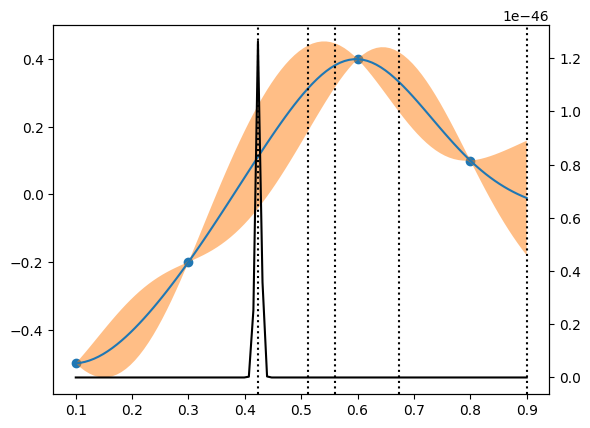

In [139]:
# Your experimental data
X_sample = np.array([[0.1], [0.3], [0.6], [0.8]])
Y_sample = np.array([-0.5, -0.2, 0.4, 0.1])

# Fit your own GP surrogate (same as skopt uses internally)
variance = 1e-6
kernel = Matern(length_scale=1.0, nu=2.5)# + WhiteKernel(noise_level=variance) # , noise_level_bounds=(0.05, 0.2)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True, # dont do in the future?
    #alpha=1,
    n_restarts_optimizer=5,
    random_state=0
)
gp_inv = clone(gp)

gp.fit(X_sample, Y_sample)

Y_sample_inv = -Y_sample
gp_inv.fit(X_sample, Y_sample_inv)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_sample, Y_sample)

x_pred = np.linspace(0.1,0.9,100)
y_pred, y_std = gp.predict(x_pred.reshape(-1, 1), return_std=True)
y_pred_inv, y_std_inv = gp_inv.predict(x_pred.reshape(-1, 1), return_std=True)

ax.plot(x_pred, y_pred)

ax.fill_between(x_pred, y_pred - y_std, y_pred + y_std, alpha=0.5)

ax2 = ax.twinx()

#ei = gaussian_ei(x_pred.reshape(-1, 1), gp_inv, np.min(y_pred_inv))
#ax2.plot(x_pred, ei, c='k')



#lcb = gaussian_lcb(x_pred.reshape(-1, 1), gp_inv)

acq, i_suggested, x_suggested, y_suggested = suggest_next_experiment(X_sample, Y_sample, x_pred.reshape(-1, 1), goal='max', model_actual=gp, acq_func_name = 'EI', n_suggestions = 5, kriging_believer = 'prediction', xi=0.1)

ax2.plot(x_pred, acq[3], c='k')
for x in x_suggested:
    ax.axvline(x, c='k', ls=':')